In [1]:
import numpy as np
import subprocess, os, glob, shutil
from shutil import copyfile
import pickle
from pickle import dump,load
import matplotlib.pyplot as plt
import math
import sys
import os.path
import time
import pandas as pd
import h5py
import copy
from tqdm import tqdm
from ast import literal_eval
import torch
import torch.nn as nn
from torch.nn import Sequential as Seq, Linear, LayerNorm, ReLU, LeakyReLU, ELU
import torch.nn.functional as F
from torch_geometric.nn import MessagePassing, knn_graph, SAGEConv, to_hetero
from torch_geometric.utils import add_self_loops, degree, to_undirected
from torch_geometric.data import Data,Dataset, InMemoryDataset, download_url, HeteroData
from torch_geometric.loader import DataLoader
import torch_geometric.transforms as T

import Model_new as Model
import run_sp_simulation
sys.path.append('/home/groups/lou/hytang/SIMGNN_Modularization')
from Data_Processing import Build_Graph_Dataset_Validation_Ctrl as Build_Graph_Dataset

def checkDist(index_new,index,XYZ,threshold):
    dist = ((XYZ['X'][index_new]-XYZ['X'][index])**2+(XYZ['Y'][index_new]-XYZ['Y'][index])**2++(XYZ['Z'][index_new]-XYZ['Z'][index])**2)**0.5
    return dist>threshold

def prepare_initial_state_graph_data(cwd,well_loc,num_inj,num_prod,num_cell,volume,perm_log,pressure_init,initial_wat_sat,num_edge,sp_pressure,inj_bhps,prod_bhps):
    x = torch.tensor([], dtype=torch.float)
    edge_attr = torch.tensor([],dtype=torch.float)
    
    inj_indices = set() # use set to check if contain
    for i in range(num_inj): #2D
        inj_indices.add(well_loc[0][i]) # well_loc from uof must be 0 based which means 0-8099!!!
    prod_indices = set()
    for i in range(num_prod): #2D
        prod_indices.add(well_loc[1][i])
        
    for cell_idx in range(num_cell):
        wi = calc_WI_formula_2d_isotropy_perm(np.exp(perm_log[cell_idx]),volume[cell_idx])
        if cell_idx in inj_indices:
            for curr_inj in range(num_inj):
                if cell_idx == well_loc[0][curr_inj]:
                    inj = curr_inj
            xi = torch.tensor([[pressure_init,initial_wat_sat,perm_log[cell_idx],volume[cell_idx],sp_pressure[cell_idx],wi,inj_bhps[inj],1,0,0]], dtype=torch.float) 
        elif cell_idx in prod_indices:
            for curr_prd in range(num_prod):
                if cell_idx == well_loc[1][curr_prd]:
                    prd = curr_prd
            xi = torch.tensor([[pressure_init,initial_wat_sat,perm_log[cell_idx],volume[cell_idx],sp_pressure[cell_idx],wi,prod_bhps[prd],0,1,0]], dtype=torch.float) 
        else:
            xi = torch.tensor([[pressure_init,initial_wat_sat,perm_log[cell_idx],volume[cell_idx],sp_pressure[cell_idx],0,0,0,0,1]], dtype=torch.float)
        x = torch.cat((x, xi),dim=0)
    
    conn_l = pickle.load(open(cwd+'/conn_l.p','rb'))
    conn_r = pickle.load(open(cwd+'/conn_r.p','rb'))
    conn_list = [conn_l,conn_r]
    conn_array = np.array(conn_list)
    edge_index = torch.tensor(conn_array, dtype=torch.long) 
    
    fileName = cwd+'/XYZ.in'
    XYZ = np.zeros((num_cell,3))
    data = pd.read_csv(fileName, delim_whitespace=True)
    XYZ[:,0] = data['X'].values
    XYZ[:,1] = data['Y'].values
    XYZ[:,2] = data['Z'].values
    fileName = cwd+'/Transmissibility.DAT'
    data = pd.read_csv(fileName, delim_whitespace=True, skiprows=[1]) # need to customize based on the file you read
    trans = data['TPFACONNS'].values[:num_edge]
    
    for idx in range(num_edge):
        displacement = torch.tensor(XYZ[edge_index[1][idx]] - XYZ[edge_index[0][idx]])
        transmissibility = torch.tensor(trans[idx])
        distance = (displacement[0]**2+displacement[1]**2)**0.5
        edge_attr_i = torch.tensor([[transmissibility,displacement[0],displacement[1],distance]], dtype=torch.float)
        edge_attr = torch.cat((edge_attr,edge_attr_i),dim=0)
    
    graph_data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    graph_data_init = T.ToUndirected()(graph_data)
    return graph_data_init

def apply_normalization_graph_data_init(graph_data_init,normalization):
    inputs = graph_data_init['x']
    inputs_edge = graph_data_init['edge_attr']

    # node feature
    inputs[:,0] = (inputs[:,0]-normalization['pressure'][0])/normalization['pressure'][1]
    inputs[:,1] = (inputs[:,1]-normalization['saturation'][0])/normalization['saturation'][1]
    inputs[:,2] = (inputs[:,2]-normalization['permeability'][0])/normalization['permeability'][1]
    inputs[:,3] = (inputs[:,3]-normalization['volume'][0])/normalization['volume'][1]
    inputs[:,4] = (inputs[:,4]-normalization['sp_pressure'][0])/normalization['sp_pressure'][1] 
    inputs[:,5] = (inputs[:,5]-normalization['wi'][0])/normalization['wi'][1] 
    inputs[:,6] = (inputs[:,6]-normalization['bhp'][0])/normalization['bhp'][1] 

    graph_data_init['x'] = inputs
    
    # edge feature
    inputs_edge[:,0] = (torch.log(inputs_edge[:,0])-normalization['transmissibility'][0])/normalization['transmissibility'][1]
    inputs_edge[:,1] = (inputs_edge[:,1]-normalization['displacement_x'][0])/normalization['displacement_x'][1]
    inputs_edge[:,2] = (inputs_edge[:,2]-normalization['displacement_y'][0])/normalization['displacement_y'][1]
    inputs_edge[:,3] = (inputs_edge[:,3]-normalization['distance'][0])/normalization['distance'][1]
    graph_data_init['edge_attr'] = inputs_edge
    
    return graph_data_init

def load_pretrained_gnn_models(pres_model_address,sat_model_address,graph_data_init_norm):
    with open(sat_model_address) as f:
        mainlist = [list(literal_eval(line)) for line in f]
    config = {
          'num_hidden_layers':mainlist[0],
          'hidden_sizes': mainlist[1],
          'num_message_passing_steps':mainlist[2],
          'latent_sizes':mainlist[3],
          'noise':mainlist[4],
          'loss_weight':mainlist[5],
          'learning_rate':mainlist[6],
          'aggr_choice':mainlist[7],
          'message_choice':mainlist[8],
          'processor_choice':mainlist[9],
          'activation_type':mainlist[10],
          'group_norm_choice':mainlist[11]
    }
    is_waterfront_loss, threshold, gamma = mainlist[12][0],mainlist[12][1],mainlist[12][2]
    is_multi_training,num_multi_training,multi_training_weight = mainlist[13][0],mainlist[13][1],mainlist[13][2]
    is_range_well_loss = mainlist[14][0]
    is_prev_features_new, num_prev_features_new = mainlist[15][0],mainlist[15][1]
    num_epochs = mainlist[16][0]
    num_epochs_loaded = mainlist[17]
    model_name_base = mainlist[18][0]
    train_val_test_runs = mainlist[19]
    batch_size_train_val_test = mainlist[20]
    is_load_opt = mainlist[21]#False#True#
    
    input_size = graph_data_init_norm.x.shape[1]
    edge_input_size = graph_data_init_norm.edge_attr.shape[1]
    output_size =  2
    is_sat = True#False#
    is_res_net = True#False#
    sat_model_list = []
    finished_trial = []
    # model_name_base ='Main_V3_presGNN_30X50_new_loss_trials_No.'
    model_path_base = '/home/groups/lou/hytang/SIMGNN_2d_unstructured_random_bhp_final/saved_models/satgnn/'
    
    if is_sat:
        index = 1
    else:
        index = 0

    save_folder = '/home/groups/lou/hytang/SIMGNN_checkpoint/structured_final/satgnn/'
    choices = {
                   'hidden':len(config['hidden_sizes']),
                    'latent':len(config['latent_sizes']),
                   'message':len(config['num_message_passing_steps']),
                    'noise':len(config['noise']),
                    'weight':len(config['loss_weight']),
                    'learning_rate':len(config['learning_rate']),
                    'aggr_choice':len(config['aggr_choice']),
                    'message_choice':len(config['message_choice']),
                    'processor_choice':len(config['processor_choice']),
                    'activation_type':len(config['activation_type']),
                    'group_norm_choice':len(config['group_norm_choice']),
                  }


    min_loss = 1e5
    count = 0

    for i in range(choices['hidden']):
        for j in range(choices['message']):
            for k in range(choices['latent']):
                for l in range(choices['noise']):
                    for m in range(choices['weight']):
                        for n in range(choices['learning_rate']):
                            for o in range(choices['aggr_choice']):
                                for p in range(choices['message_choice']):
                                    for q in range(choices['processor_choice']):
                                        for r in range(choices['activation_type']):
                                            for s in range(choices['group_norm_choice']):
                                                count = count + 1
                                                print("We are at architecture No."+str(count))
                                                if count in finished_trial:
                                                    print("This one is done previously!")
                                                    continue
                                                model_name=model_name_base+str(count)
                                                model_path =model_path_base+model_name

                                                hidden_sizes = config['hidden_sizes'][i]
                                                num_hidden_layers = config['num_hidden_layers'][i]
                                                num_message_passing_steps = config['num_message_passing_steps'][j]
                                                latent_size = config['latent_sizes'][k]
                                                pressure_noise = [0,config['noise'][l][0]]
                                                saturation_noise = [0,config['noise'][l][1]]
                                                alpha = config['loss_weight'][m][0] # ctrl the weight of MAE loss
                                                beta = config['loss_weight'][m][1] # ctrl the weight of well loss
                                                aggr_choice = config['aggr_choice'][o]
                                                message_choice = config['message_choice'][p]
                                                processor_choice = config['processor_choice'][q]
                                                activation_type = config['activation_type'][r]
                                                group_norm_choice = config['group_norm_choice'][s]

                                                torch.cuda.empty_cache()
                                                device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
                                                model = Model.SIMGNN(input_size, edge_input_size,output_size, latent_size, hidden_sizes, num_hidden_layers, 
                                                                     num_message_passing_steps,aggr_choice,message_choice,is_res_net,processor_choice,activation_type,group_norm_choice).to(device)
                                                load_model = model
                                                load_model.load_state_dict(torch.load(model_path))
                                                load_model.eval()

                                                sat_model_list.append(load_model)

    with open(pres_model_address) as f:
        mainlist = [list(literal_eval(line)) for line in f]
    config = {
          'num_hidden_layers':mainlist[0],
          'hidden_sizes': mainlist[1],
          'num_message_passing_steps':mainlist[2],
          'latent_sizes':mainlist[3],
          'noise':mainlist[4],
          'loss_weight':mainlist[5],
          'learning_rate':mainlist[6],
          'aggr_choice':mainlist[7],
          'message_choice':mainlist[8],
          'processor_choice':mainlist[9],
          'activation_type':mainlist[10],
          'group_norm_choice':mainlist[11]
    }
    is_waterfront_loss, threshold, gamma = mainlist[12][0],mainlist[12][1],mainlist[12][2]
    is_multi_training,num_multi_training,multi_training_weight = mainlist[13][0],mainlist[13][1],mainlist[13][2]
    is_range_well_loss = mainlist[14][0]
    is_prev_features_new, num_prev_features_new = mainlist[15][0],mainlist[15][1]
    num_epochs = mainlist[16][0]
    num_epochs_loaded = mainlist[17]
    model_name_base = mainlist[18][0]
    train_val_test_runs = mainlist[19]
    batch_size_train_val_test = mainlist[20]



    # for tunning hyperparameter purpose only!!!
    is_save = True#False#
    is_sat = False#True#
    is_res_net = True#False#
    pres_model_list = []
    finished_trial = []
    model_path_base = '/home/groups/lou/hytang/SIMGNN_2d_unstructured_random_bhp_final/saved_models/presgnn/'

    if is_sat:
        index = 1
    else:
        index = 0

    save_folder = '/home/groups/lou/hytang/SIMGNN_checkpoint/structured_final/presgnn/'
    choices = {
                   'hidden':len(config['hidden_sizes']),
                    'latent':len(config['latent_sizes']),
                   'message':len(config['num_message_passing_steps']),
                    'noise':len(config['noise']),
                    'weight':len(config['loss_weight']),
                    'learning_rate':len(config['learning_rate']),
                    'aggr_choice':len(config['aggr_choice']),
                    'message_choice':len(config['message_choice']),
                    'processor_choice':len(config['processor_choice']),
                    'activation_type':len(config['activation_type']),
                    'group_norm_choice':len(config['group_norm_choice']),
                  }


    min_loss = 1e5
    count = 0

    for i in range(choices['hidden']):
        for j in range(choices['message']):
            for k in range(choices['latent']):
                for l in range(choices['noise']):
                    for m in range(choices['weight']):
                        for n in range(choices['learning_rate']):
                            for o in range(choices['aggr_choice']):
                                for p in range(choices['message_choice']):
                                    for q in range(choices['processor_choice']):
                                        for r in range(choices['activation_type']):
                                            for s in range(choices['group_norm_choice']):
                                                count = count + 1
                                                print("We are at architecture No."+str(count))
                                                if count in finished_trial:
                                                    print("This one is done previously!")
                                                    continue
                                                model_name=model_name_base+str(count)
                                                model_path =model_path_base+model_name

                                                hidden_sizes = config['hidden_sizes'][i]
                                                num_hidden_layers = config['num_hidden_layers'][i]
                                                num_message_passing_steps = config['num_message_passing_steps'][j]
                                                latent_size = config['latent_sizes'][k]
                                                pressure_noise = [0,config['noise'][l][0]]
                                                saturation_noise = [0,config['noise'][l][1]]
                                                alpha = config['loss_weight'][m][0] # ctrl the weight of MAE loss
                                                beta = config['loss_weight'][m][1] # ctrl the weight of well loss
                                                aggr_choice = config['aggr_choice'][o]
                                                message_choice = config['message_choice'][p]
                                                processor_choice = config['processor_choice'][q]
                                                activation_type = config['activation_type'][r]
                                                group_norm_choice = config['group_norm_choice'][s]

                                                torch.cuda.empty_cache()
                                                device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
                                                model = Model.SIMGNN(input_size, edge_input_size,output_size, latent_size, hidden_sizes, num_hidden_layers, 
                                                                     num_message_passing_steps,aggr_choice,message_choice,is_res_net,processor_choice,activation_type,group_norm_choice).to(device)
                                                load_model = model
                                                load_model.load_state_dict(torch.load(model_path))
                                                load_model.eval()

                                                pres_model_list.append(load_model)

    return pres_model_list[0],sat_model_list[0]

def post_process_surrogate_output_reverse_normalization(pred_record,num_ts,normalization):
    P = []
    Sw = []
    for i in range(num_ts):
        pred = pred_record[i]
        p_norm = pred[:,0]
        sw_norm = pred[:,1]
        p = p_norm*normalization['pressure'][1]+normalization['pressure'][0]
        sw = sw_norm*normalization['saturation'][1]+normalization['saturation'][0]
        P.append(p.to('cpu').numpy())
        Sw.append(sw.to('cpu').numpy())
    P = np.array(P)
    Sw = np.array(Sw)
    return P, Sw

def calc_WI_formula_2d_isotropy_perm(k,size,skin_factor=0):
    # may need some additional unit conversion later
    cdarcy = 1#0.008527 # cdarcy should be done inside simulator well model not here
    pi = 3.1415926
    h = 32.8
    dx = (size/h)**0.5
    dy = dx
    r0 = 0.28*((k/k)**0.5*dx**2+(k/k)**0.5*dy**2)**0.5/((k/k)**0.25+(k/k)**0.25)
    rperf = 0.3048/2
    wi = 2*pi*cdarcy*k*h/(np.log(r0/rperf)+skin_factor)
    return wi

def Read_ADGPRS_Var_sp_pressure(curr_dir):
    adgprs_output = os.path.join(curr_dir, 'Output.vars.h5')

    fid = h5py.File(adgprs_output, 'r')
    P = np.array(fid.get('FLOW_CELL')['pres'])
    fid.close()
    
    return P[:,-1]

# USE WELL MODEL TO CALC RATES NOT THEORY MODEL!!!!
def model_loading(input_size,output_size,model_path_base,model_name_base,config,choices):
    count = 0
    model_list = []
    for i in range(choices['hidden']):
        for j in range(choices['learning_rate']):
            for k in range(choices['activation_type']):
                for l in range(choices['group_norm_choice']):
                    count = count + 1
                    model_name=model_name_base+str(count)
                    model_path =model_path_base+model_name

                    hidden_sizes = config['hidden_sizes'][i]
                    num_hidden_layers = config['num_hidden_layers'][i]
                    activation_type = config['activation_type'][k]
                    group_norm_choice = config['group_norm_choice'][l]

                    torch.cuda.empty_cache()
                    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
                    model = Model.MLP(input_size,hidden_sizes,output_size,num_hidden_layers,activation_type,group_norm_choice).to(device)
                    model.load_state_dict(torch.load(model_path))
                    model.eval()
                    model_list.append(model)
    return model_list

def calculate_surrogate_rates(curr_dir,pred_record,graph_data_init_norm,num_cell,num_inj,num_prod,num_ts,wellLoc,volume,perm,device,num_hops):
    num_prd = num_prod
    conn_l = pickle.load(open(curr_dir+'/conn_l.p','rb'))
    conn_r = pickle.load(open(curr_dir+'/conn_r.p','rb'))
    # load normalization info
    well_dir = os.path.join(curr_dir, 'train_val_test_data_rollout_from_first_with_'+str(num_hops)+'_hops_of_neighor_features')
    file = open(well_dir, 'rb')
    well_data = pickle.load(file)
    file.close()
    [_, _, _, normalization_rate] = well_data['inj']
    
    input_size = 14
    output_size = 1
    
    # load orate wrate inj_rate well models
    oil_index = 2 #0-18
    model_path_base = '/home/groups/lou/hytang/SIMGNN_2d_unstructured_random_bhp_final/saved_models/well_correction_model/'
    model_name_base ='Well_model_well_ctrl_MLP_prd_orate_with_satgnn_stage2_trial9_presgnn_stage2_trial9_input_1hop_neighbor_features_stage1_No.'
    config = {
              'num_hidden_layers':[3,3,4],
              'hidden_sizes': [[64,64,64],[128,128,128],[64,64,64,64]],
              'learning_rate':[0.001],
              'activation_type':['relu','elu','leakyrelu'],
              'group_norm_choice':['None','MLP']
             }
    choices = {
                'hidden':len(config['hidden_sizes']),
                'learning_rate':len(config['learning_rate']),
                'activation_type':len(config['activation_type']),
                'group_norm_choice':len(config['group_norm_choice']),
              }
    oil_rate_model_list = model_loading(input_size,output_size,model_path_base,model_name_base,config,choices)

    water_index = 13 #0-15
    model_path_base = '/home/groups/lou/hytang/SIMGNN_2d_unstructured_random_bhp_final/saved_models/well_correction_model/'
    model_name_base ='Well_model_well_ctrl_MLP_prd_wrate_with_satgnn_stage2_trial9_presgnn_stage2_trial9_input_new_loss_1hop_neighbor_features_stage1_No.'
    config = {
              'num_hidden_layers':[2,3],
              'hidden_sizes': [[128,128],[128,128,128]],
              'learning_rate':[0.001, 0.0001],
              'activation_type':['relu','leakyrelu'],
              'group_norm_choice':['None','MLP']
             }
    choices = {
                'hidden':len(config['hidden_sizes']),
                'learning_rate':len(config['learning_rate']),
                'activation_type':len(config['activation_type']),
                'group_norm_choice':len(config['group_norm_choice']),
              }
    water_rate_model_list = model_loading(input_size,output_size,model_path_base,model_name_base,config,choices)

    inj_index = 1 #0-11
    model_path_base = '/home/groups/lou/hytang/SIMGNN_2d_unstructured_random_bhp_final/saved_models/well_correction_model/'
    model_name_base ='Well_model_well_ctrl_MLP_inj_rate_with_satgnn_stage2_trial9_presgnn_stage2_trial9_input_new_loss_1hop_neighbor_features_stage1_No.'
    config = {
              'num_hidden_layers':[2,3,3,4],
              'hidden_sizes': [[128,128],[64,64,64],[128,128,128],[64,64,64,64]],
              'learning_rate':[0.001],
              'activation_type':['relu','elu','leakyrelu'],
              'group_norm_choice':['MLP']
             }
    choices = {
                'hidden':len(config['hidden_sizes']),
                'learning_rate':len(config['learning_rate']),
                'activation_type':len(config['activation_type']),
                'group_norm_choice':len(config['group_norm_choice']),
              }
    inj_rate_model_list = model_loading(input_size,output_size,model_path_base,model_name_base,config,choices)
    
    oil_rate_model=oil_rate_model_list[oil_index]
    water_rate_model=water_rate_model_list[water_index] #[0-3] 0
    inj_rate_model=inj_rate_model_list[inj_index]
    
    # prepare the inputs for the calc of rates (normalized pres,sat,k,v,sp_pres,wi,bhp)
    data_inj_rate_x = []
    data_prd_orate_x = []
    data_prd_wrate_x = []

    for i in range(num_ts):  
        sim_idx, sim_time_idx = divmod(i,num_ts)
        well_idx = sim_idx+1
        well = wellLoc[well_idx]     
        for inj in range(num_inj):   
            curr_loc = (well[0][inj])
            pres,sw,k,v,sp_pres,wi,bhp = feature_preparation_helper(graph_data_init_norm,pred_record,i,curr_loc)
            pres_neighbor_avg,sw_neighbor_avg,k_neighbor_avg,v_neighbor_avg,sp_pres_neighbor_avg,wi_neighbor_avg,bhp_neighbor_avg = feature_preparation_neighbor_average(num_hops,conn_l,conn_r,graph_data_init_norm,pred_record,i,curr_loc)
            data_inj_rate_x.append(np.array([pres,sw,k,v,sp_pres,wi,bhp,pres_neighbor_avg,sw_neighbor_avg,k_neighbor_avg,v_neighbor_avg,sp_pres_neighbor_avg,wi_neighbor_avg,bhp_neighbor_avg]))

        for prd in range(num_prd):
            curr_loc = (well[1][prd])
            pres,sw,k,v,sp_pres,wi,bhp = feature_preparation_helper(graph_data_init_norm,pred_record,i,curr_loc)
            pres_neighbor_avg,sw_neighbor_avg,k_neighbor_avg,v_neighbor_avg,sp_pres_neighbor_avg,wi_neighbor_avg,bhp_neighbor_avg = feature_preparation_neighbor_average(num_hops,conn_l,conn_r,graph_data_init_norm,pred_record,i,curr_loc)
            data_prd_orate_x.append(np.array([pres,sw,k,v,sp_pres,wi,bhp,pres_neighbor_avg,sw_neighbor_avg,k_neighbor_avg,v_neighbor_avg,sp_pres_neighbor_avg,wi_neighbor_avg,bhp_neighbor_avg]))
            data_prd_wrate_x.append(np.array([pres,sw,k,v,sp_pres,wi,bhp,pres_neighbor_avg,sw_neighbor_avg,k_neighbor_avg,v_neighbor_avg,sp_pres_neighbor_avg,wi_neighbor_avg,bhp_neighbor_avg]))

    data_inj_rate_x = np.array(data_inj_rate_x)
    data_prd_orate_x = np.array(data_prd_orate_x)
    data_prd_wrate_x = np.array(data_prd_wrate_x)
    
    # calculate rates
    inj_rate_pred = np.zeros((1,num_inj,num_ts))
    prd_orate_pred = np.zeros((1,num_prod,num_ts))
    prd_wrate_pred = np.zeros((1,num_prod,num_ts))
    
    # write a function to calculate per case per timestep per well rates, input p sw bhp k output the rate
    for real in range(1):
        well_idx = real+1
        well = wellLoc[well_idx]   
        # prepare the inputs for the calc of rates
        for ts in range(num_ts):
            for i in range(num_inj):
                idx = real*num_ts*num_inj + ts*num_inj + i
                inj_x = torch.from_numpy(data_inj_rate_x[idx,:]).to(device).reshape((1,data_inj_rate_x.shape[-1]))
                inj_rate_pred[real,i,ts] = inj_rate_model(inj_x)*normalization_rate['inj_rate'][1] + normalization_rate['inj_rate'][0]
            for i in range(num_prd):
                idx = real*num_ts*num_prd + ts*num_prd + i
                oil_x = torch.from_numpy(data_prd_orate_x[idx,:]).to(device).reshape((1,data_prd_orate_x.shape[-1]))
                prd_orate_pred[real,i,ts] = oil_rate_model(oil_x)*normalization_rate['prod_orate'][1] + normalization_rate['prod_orate'][0]
                water_x = torch.from_numpy(data_prd_wrate_x[idx,:]).to(device).reshape((1,data_prd_wrate_x.shape[-1]))
                prd_wrate_pred[real,i,ts] = water_rate_model(water_x)*normalization_rate['prod_wrate'][1] + normalization_rate['prod_wrate'][0]    

    return inj_rate_pred[0],prd_wrate_pred[0],prd_orate_pred[0]

def find_unstructured_cell_index_from_X_Y(x,y,XYZ):
    min_dist = 1e5
    cell_idx = -1
    for i in range(len(XYZ)):
        curr_dist = ((x-XYZ['X'][i])**2+(y-XYZ['Y'][i])**2)**0.5
        if curr_dist < min_dist:
            min_dist = curr_dist
            cell_idx = i
    return cell_idx # 0 -based cell_idx

    
def search_neighbor_node_features(num_hops, curr_loc, conn_l, conn_r):
    visited = set([curr_loc])  # Include the initial node to avoid revisiting it
    current_nodes = [curr_loc]
    
    for _ in range(num_hops):
        next_nodes = []
        for node in current_nodes:
            # Search for connections of the current node
            left_indices = [i for i, x in enumerate(conn_l) if x == node]
            right_indices = [i for i, x in enumerate(conn_r) if x == node]
            
            for li in left_indices:
                if conn_r[li] not in visited:
                    next_nodes.append(conn_r[li])
                    visited.add(conn_r[li])  # Update visited immediately
            
            for ri in right_indices:
                if conn_l[ri] not in visited:
                    next_nodes.append(conn_l[ri])
                    visited.add(conn_l[ri])  # Update visited immediately
        
        current_nodes = next_nodes  # Move to next hop
    
    # Convert visited set to list and remove the initial node
    result = list(visited)
    result.remove(curr_loc)
    return result

def feature_preparation_helper(graph_data_init_norm,pred_record,i,curr_loc):
    k,v,sp_pres = graph_data_init_norm['x'][curr_loc,2].cpu(),graph_data_init_norm['x'][curr_loc,3].cpu(),graph_data_init_norm['x'][curr_loc,4].cpu()
    wi,bhp = graph_data_init_norm['x'][curr_loc,5].cpu(),graph_data_init_norm['x'][curr_loc,6].cpu()
    pres,sw = pred_record[i][curr_loc][0].cpu(),pred_record[i][curr_loc][1].cpu()
    
    return pres,sw,k,v,sp_pres,wi,bhp

def feature_preparation_neighbor_average(num_hops,conn_l,conn_r,graph_data_init_norm,pred_record,i,curr_loc):
    pres_neighbor_avg,sw_neighbor_avg,k_neighbor_avg,v_neighbor_avg,sp_pres_neighbor_avg,wi_neighbor_avg,bhp_neighbor_avg = 0,0,0,0,0,0,0
    neighbor_indices = search_neighbor_node_features(num_hops, curr_loc, conn_l, conn_r)
    for neighbor_loc in neighbor_indices:
        pres,sw,k,v,sp_pres,wi,bhp = feature_preparation_helper(graph_data_init_norm,pred_record,i,neighbor_loc)
        pres_neighbor_avg += pres/len(neighbor_indices)
        sw_neighbor_avg += sw/len(neighbor_indices)
        k_neighbor_avg += k/len(neighbor_indices)
        v_neighbor_avg += v /len(neighbor_indices)
        sp_pres_neighbor_avg += sp_pres/len(neighbor_indices)
        wi_neighbor_avg += wi/len(neighbor_indices)
        bhp_neighbor_avg += bhp/len(neighbor_indices)
    
    return pres_neighbor_avg,sw_neighbor_avg,k_neighbor_avg,v_neighbor_avg,sp_pres_neighbor_avg,wi_neighbor_avg,bhp_neighbor_avg

/home/groups/lou/hytang/anaconda3/envs/SIMGNN_SERC2/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Step 1. generate GNN pressure and stauration

In [2]:
infile = 'x_current_ind.input'
outfile = 'ob.txt'

# note: the input well loc should be 0-based (0-8099) but the output well loc in Well.DAT should be 1-based (1-8100)
start_time = time.time()
num_cell = 6045
num_inj=5
inj_bhps=[] #unit: bar
num_prod=5
prod_bhps=[] #unit: bar
num_well = num_inj+num_prod
num_ts = 50
time_per_step = 30
initial_wat_sat = 0.2#0.0 #
poro = 0.1
grids = [6045,1,1]
num_edge = 17738
# gridSize = [32.8,32.8,32.8]
Nc = grids[0]*grids[1]*grids[2]
initial_pres=200 * np.ones(Nc) #unit: bar
pressure_init = initial_pres[0]
saturation_init = initial_wat_sat
cwd = os.getcwd()
min_well_dist = 100
num_hops = 1

input_infos = np.loadtxt(infile) # first 2xn_w [X,Y] pairs for the n_w well locations, last n_w for the injectors and producers BHPs
wellLoc = {}
wellLoc_load = []

# prepare the initial state graph data
fileName = cwd+'/Volume.DAT'
volume = np.zeros(num_cell)
with open(fileName) as f:
    lines = f.readlines()
for i in range(len(lines)-2):
    volume[i] = float(lines[i+1])

fileName = cwd+'/PEBI_PERM.dat'
perm = np.zeros(num_cell)
perm_log = np.zeros(num_cell)
with open(fileName) as f:
    lines = f.readlines()
for i in range(len(lines)-2):
    perm[i] = float(lines[i+1])
    perm_log[i] = math.log(perm[i])

# step 101. before anything we need check if well distance is reasonable, if not just return NPV = 0
XYZ = pd.read_csv('XYZ.in', delim_whitespace=True)


for inj in range(num_inj):
    x = input_infos[inj*2]
    y = input_infos[inj*2+1]
    wellLoc_load.append(find_unstructured_cell_index_from_X_Y(x,y,XYZ))
    inj_bhps.append(input_infos[2*num_well+inj])
for prd in range(num_prod):
    x = input_infos[2*num_inj+prd*2]
    y = input_infos[2*num_inj+prd*2+1]
    wellLoc_load.append(find_unstructured_cell_index_from_X_Y(x,y,XYZ))
    prod_bhps.append(input_infos[2*num_well+num_inj+prd])

wellLoc[1] = [[wellLoc_load[0], wellLoc_load[1], wellLoc_load[2], wellLoc_load[3], wellLoc_load[4]], [wellLoc_load[5], wellLoc_load[6], wellLoc_load[7], wellLoc_load[8], wellLoc_load[9]]]

In [3]:
wellLoc

{1: [[4363, 210, 5126, 2144, 2414], [825, 1548, 159, 1143, 134]]}

In [4]:
inj_bhps

[241.481, 310.0, 210.0, 255.356, 286.605]

In [5]:
prod_bhps

[122.402, 137.21, 143.242, 97.6475, 73.0797]

In [6]:
is_well_dist = True
wells = []
for curr_idx in range(num_inj):
    wells.append(wellLoc[1][0][curr_idx])
for curr_idx in range(num_prod):
    wells.append(wellLoc[1][1][curr_idx])

for curr_idx in range(num_inj+num_prod):
    for new_idx in range(curr_idx):
        if not checkDist(wells[curr_idx],wells[new_idx],XYZ,min_well_dist):
            is_well_dist = False
            
if not is_well_dist:
    output = [-1000.0] 
    np.savetxt(outfile,output)
else:
    # PREPARE THE SP_PRESSURE BY RUNNING SIMULATION HERE!!!!
    run_sp_simulation.run_sp_simulation_main(infile)
    sp_pressure = Read_ADGPRS_Var_sp_pressure(cwd)
    tot_time = time.time() - start_time
    print("--- %s seconds ---" % (tot_time))
    graph_data_init = prepare_initial_state_graph_data(cwd,wellLoc[1],num_inj,num_prod,num_cell,volume,perm_log,pressure_init,initial_wat_sat,num_edge,sp_pressure,inj_bhps,prod_bhps)
    # perform normalization
    # first ele is min, second ele is max-min
    # cdarcy = 0.008527 # the only reason we do this here is inconsistency in structured case, not gonna use this factor later for unstructured case!!!
    known_norm = {'pressure': [torch.tensor(90.), torch.tensor(220.)],
             'saturation': [torch.tensor(0.), torch.tensor(1.)],
             'permeability': [torch.tensor(-0.9383), torch.tensor(9.7259)],
             'volume': [torch.tensor(25589.6406), torch.tensor(54019.9531)],
             'sp_pressure': [torch.tensor(50.), torch.tensor(260.)],
             'wi': [torch.tensor(0.), torch.tensor(225597.4375)],
             'bhp': [torch.tensor(0.), torch.tensor(310.)],
             'transmissibility': [torch.tensor(-7.6815), torch.tensor(14.8873)],
             'displacement_x': [torch.tensor(-62.1647), torch.tensor(127.4432)],
             'displacement_y': [torch.tensor(-63.2738), torch.tensor(126.2220)],
             'distance': [torch.tensor(27.5219), torch.tensor(41.1963)]}
    normalization=known_norm
    graph_data_init_norm = apply_normalization_graph_data_init(graph_data_init,known_norm)

    # step 2. load and rollout the gnn models to predict the pressure and saturation
    pres_model_name = '/home/groups/lou/hytang/SIMGNN_2d_unstructured_random_bhp_final/python_training_presgnn/python_systematic_training_framework_resnet_large_dataset_stage2_trial9_input.txt'
    sat_model_name = '/home/groups/lou/hytang/SIMGNN_2d_unstructured_random_bhp_final/python_training_satgnn/python_systematic_training_framework_satgnn_large_dataset_stage2_trial9_input.txt'

    pres_model,sat_model = load_pretrained_gnn_models(pres_model_name,sat_model_name,graph_data_init_norm)

    data = copy.deepcopy(graph_data_init_norm)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    pred_record = []

    for i in range(num_ts):
        torch.set_grad_enabled(False)
        data = data.to(device, non_blocking=True)
        pres_model.eval();sat_model.eval()
        pres_pred = pres_model(data)
        sat_pred = sat_model(data)
        pred_normal = pres_pred
        pred_normal[:,1] = sat_pred[:,1]
        data.x[:,0] = pred_normal[:,0]
        data.x[:,1] = pred_normal[:,1]
    #     pred = Build_Graph_Dataset.apply_normalization_backward(normalization,pred_normal,'both') 
        pred_record.append(pred_normal) #here this is normalized data not P and Sw directly!!!
        data = data.to('cpu')

    # step 3. calculate rates based on surrogate state variable outputs
    P, Sw = post_process_surrogate_output_reverse_normalization(pred_record,num_ts,known_norm)
    inj_rate,prd_wrate,prd_orate = calculate_surrogate_rates(cwd,pred_record,graph_data_init_norm,num_cell,num_inj,num_prod,num_ts,wellLoc,volume,perm,device,num_hops)

    # Step 4. calculate NPV, rate constraint etc as objective functions.
    stb2m3 = 0.158987
    Po = 60#/stb2m3
    Pw = 3#/stb2m3
    Pinj = 2#/stb2m3
    r = 0.1 #discount rate
    npv = 0
    for n in range(num_ts):
        val = 0
        dt = time_per_step
        for j in range(num_prod):
            val += dt*(Po * prd_orate[j,n] - Pw * prd_wrate[j,n])/stb2m3
        for k in range(num_inj):
            val += dt * Pinj * inj_rate[k,n]/stb2m3  # inj_rate is negative value
        npv += val/(1+r)**(time_per_step*(n+1)//365)

    output = [npv,np.max(abs(inj_rate)),np.max(abs(prd_wrate)),np.max(abs(prd_orate))] # there can be more things considered here!!! use list to avoid bugs!
    np.savetxt(outfile,output)
    tot_time = time.time() - start_time
    np.savetxt('time_out.txt',[tot_time])
    print("--- %s seconds ---" % (tot_time))


--- 79.09423518180847 seconds ---
We are at architecture No.1
We are at architecture No.1
--- 84.38503813743591 seconds ---


In [8]:
output

[1020376973.4030302, 5022.0, 5196.01953125, 1675.197021484375]

In [70]:
output[0]/1e9

1.0203769734030301

In [71]:
output[1]/1e3

5.022

In [72]:
output[2]/1e3

5.19601953125

In [73]:
output[3]/1e3

1.675197021484375

# Step 2. read simulation pressure and saturation

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import h5py
def Read_ADGPRS_Var(nconfig,main_dir):
    P, Sw, time = [], [], []
    for i in nconfig:
#         if i % 100 == 0:
#             print('processed {} runs'.format(i + 1))
#         path = os.path.join(main_dir, 'Case{}'.format(i))
        path = main_dir
        adgprs_output = os.path.join(path, 'Output.vars.h5')

        fid = h5py.File(adgprs_output, 'r')
        cur_sat = np.array(fid.get('FLOW_CELL')['sat_np=1'])
        cur_p = np.array(fid.get('FLOW_CELL')['pres'])
        P.append(cur_p)
        Sw.append(cur_sat) 
        fid.close()
    return P,Sw

# careful here we have n+1 timestep with time 0 and time 1 basically same thing, just ignore time 0 and start with time 1!!!
# write a helper function that can read raw data from config_i files and get a object sim_data with state variables
def load_adgprs_sim_data_static(config,main_dir):
    # then, let's laod the volume data
    fileName = main_dir+'/Volume.DAT'
    volume = np.zeros(Nc)

    with open(fileName) as f:
        lines = f.readlines()
    for i in range(len(lines)-2):
        volume[i] = float(lines[i+1])
    
    # finally, we load the transmissibility and coordinate XYZ data
    fileName = main_dir+'/Transmissibility.DAT'
    data = pd.read_csv(fileName, delim_whitespace=True, skiprows=[1]) # need to customize based on the file you read
    trans = data['TPFACONNS'].values[:num_edges]
    
    fileName = main_dir+'/XYZ.in'
    XYZ = np.zeros((Nc,3))
    data = pd.read_csv(fileName, delim_whitespace=True)#, skiprows=[1])
    XYZ[:,0] = data['X'].values
    XYZ[:,1] = data['Y'].values
    XYZ[:,2] = data['Z'].values

        
    return volume,trans,XYZ


In [27]:
#fuction testing here, p[num_config][num_cell,num_timestep], sw[num_config][num_cell,num_timestep]
nconfig = [0] # Case1, 3, and 4 are structured cases
main_dir ='/oak/stanford/schools/ees/smart_fields/hytang/uof_optimization_workflow/GNN_surrogate/Optimizations/WPO_one_BHP_ctrl_unstructured/gnnEval_testing/corresponding_sim_results/'#'/oak/stanford/schools/ees/smart_fields/hytang/simulation_database/unstructured_model/dataset_5inj_5prd_unstructured_2000days/raw'
p,sw = Read_ADGPRS_Var(nconfig,main_dir) 
p=np.array(p);sw=np.array(sw)

# Step 3. Visualization both gnn and sim results

In [28]:
num_ts

50

In [29]:
sw.shape

(1, 6045, 56)

In [30]:
Sw.shape

(50, 6045)

In [31]:
sw[0,:,1]

array([0.30842593, 0.44059755, 0.423514  , ..., 0.19996391, 0.1999613 ,
       0.19996141])

In [32]:
Sw[0,:]

array([0.31402725, 0.43626463, 0.41402048, ..., 0.19995707, 0.19995996,
       0.1999704 ], dtype=float32)

In [33]:
sim_pres = p[:,:,1:num_ts+1]
sim_sat = sw[:,:,1:num_ts+1]

In [34]:
gnn_pres = P.transpose().reshape(sim_pres.shape)
gnn_sat = Sw.transpose().reshape(sim_sat.shape)

In [35]:
Sw.shape

(50, 6045)

In [36]:
gnn_sat.shape

(1, 6045, 50)

In [50]:
# start_time = time.time()
num_cell = 6045
num_inj=5
inj_bhps=[] #unit: bar
num_prod=5
prod_bhps=[] #unit: bar
num_well = num_inj+num_prod
num_ts = 50
time_per_step = 30
initial_wat_sat = 0.2#0.0 #
poro = 0.1
grids = [6045,1,1]
num_edge = 17738
# gridSize = [32.8,32.8,32.8]
Nc = grids[0]*grids[1]*grids[2]
initial_pres=200 * np.ones(Nc) #unit: bar
pressure_init = initial_pres[0]
saturation_init = initial_wat_sat
cwd = os.getcwd()
min_well_dist = 100
num_edges=num_edge

In [51]:
Sw.shape

(50, 6045)

In [52]:
sw.shape

(1, 6045, 56)

In [53]:
# for each test config, we load the true state map v.s. predicted state map and calculate their diff state map
num_reals = len(nconfig)
x_struct = 90
y_struct = 90
dx_struct = 32.8
dy_struct = 32.8
time_step = time_per_step

x_dim = grids[0]
y_dim = grids[1]
test_batch_size = 1

volume,trans,XYZ = load_adgprs_sim_data_static(0,main_dir)

In [54]:
saturation_true = np.zeros((num_reals,num_ts,x_dim,y_dim)) #(#reals,#timestep,#x_dim,#y_dim)
saturation_pred = np.zeros((num_reals,num_ts,x_dim,y_dim)) #(#reals,#timestep,#x_dim,#y_dim)
saturation_diff = np.zeros((num_reals,num_ts,x_dim,y_dim)) #(#reals,#timestep,#x_dim,#y_dim)

# file in the blank from tensors for saturation_true
state_var = sim_sat
for i in range(num_reals):
    for j in range(num_ts):
#         idx = i*num_ts+j
        saturation_tensor = state_var[i,:,j]
        saturation = saturation_tensor.reshape((x_dim,y_dim))
        saturation_true[i,j] = saturation 

state_var = gnn_sat
for i in range(num_reals):
    for j in range(num_ts):
#         idx = i*num_ts+j
        saturation_tensor = state_var[i,:,j]
        saturation = saturation_tensor.reshape((x_dim,y_dim))
        saturation_pred[i,j] = saturation 
        
saturation_diff = np.abs(saturation_pred - saturation_true)

In [55]:
pressure_true = np.zeros((num_reals,num_ts,x_dim,y_dim)) #(#reals,#timestep,#x_dim,#y_dim)
pressure_pred = np.zeros((num_reals,num_ts,x_dim,y_dim)) #(#reals,#timestep,#x_dim,#y_dim)
pressure_diff = np.zeros((num_reals,num_ts,x_dim,y_dim)) #(#reals,#timestep,#x_dim,#y_dim)

# file in the blank from tensors for saturation_true
state_var = sim_pres
for i in range(num_reals):
    for j in range(num_ts):
#         idx = i*num_ts+j
        saturation_tensor = state_var[i,:,j]
        saturation = saturation_tensor.reshape((x_dim,y_dim))
        pressure_true[i,j] = saturation 

state_var = gnn_pres
for i in range(num_reals):
    for j in range(num_ts):
#         idx = i*num_ts+j
        saturation_tensor = state_var[i,:,j]
        saturation = saturation_tensor.reshape((x_dim,y_dim))
        pressure_pred[i,j] = saturation 
        
pressure_diff = np.abs(pressure_pred - pressure_true)

In [56]:
import Visualization_Unstructured_Trickies
# using tricks to represent unstructured cells in structured format
sat_struct = Visualization_Unstructured_Trickies.unstructure_2_structure_trick(len(nconfig), num_ts, Nc, x_struct, y_struct, dx_struct, dy_struct, XYZ,
                                                                                  saturation_true, saturation_pred, saturation_diff)
pres_struct = Visualization_Unstructured_Trickies.unstructure_2_structure_trick(num_reals, num_ts, Nc, x_struct, y_struct, dx_struct, dy_struct, XYZ,
                                                                                  pressure_pred, pressure_true, pressure_diff)

In [57]:
plt.jet()

<Figure size 640x480 with 0 Axes>

timestep:50
time:1500.0days


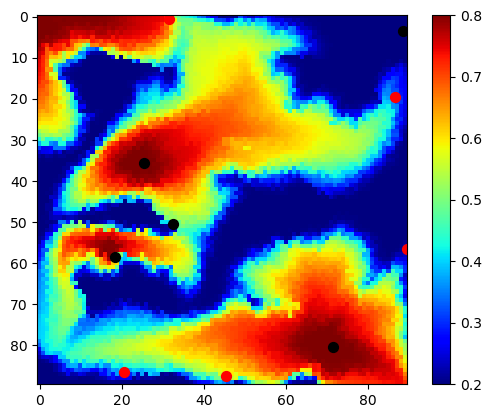

true


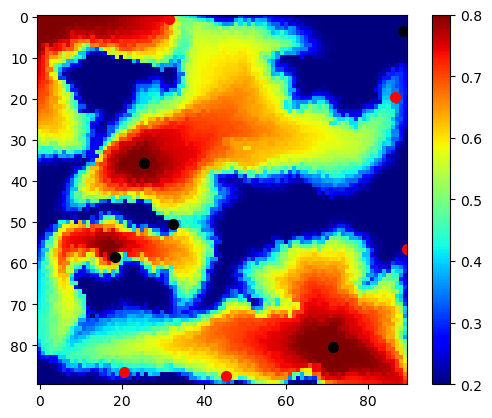

pred


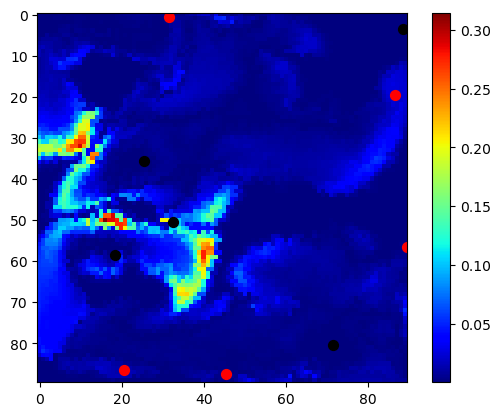

diff


In [58]:
real =0
start_ts = 49

well = wellLoc[1]
num_inj = len(well[0])
num_prd = len(well[1])
total_time = 1500.0 #unit: day 
time0= total_time//num_ts
for ts in range(start_ts,num_ts):
    print("timestep:{}".format(ts+1));print("time:{}days".format(time0*(ts+1)))
    plt.figure()
    p1=plt.imshow(sat_struct['true'][real][ts])
    for i in range(num_inj):
        well_x,well_y = Visualization_Unstructured_Trickies.unstructure_2_structure_trick_single_well(Nc,dx_struct,dy_struct,well[0][i], XYZ)
        plt.scatter(well_y,well_x, s=50, c='black', marker='o') # inj
    for i in range(num_prd):
        well_x,well_y = Visualization_Unstructured_Trickies.unstructure_2_structure_trick_single_well(Nc,dx_struct,dy_struct,well[1][i], XYZ)
        plt.scatter(well_y,well_x,  s=50, c='red', marker='o') # prod
    plt.colorbar(p1)
    plt.show()
    print('true')
    p2=plt.imshow(sat_struct['pred'][real][ts])
    for i in range(num_inj):
        well_x,well_y = Visualization_Unstructured_Trickies.unstructure_2_structure_trick_single_well(Nc,dx_struct,dy_struct,well[0][i], XYZ)
        plt.scatter(well_y,well_x, s=50, c='black', marker='o') # inj
    for i in range(num_prd):
        well_x,well_y = Visualization_Unstructured_Trickies.unstructure_2_structure_trick_single_well(Nc,dx_struct,dy_struct,well[1][i], XYZ)
        plt.scatter(well_y,well_x,  s=50, c='red', marker='o') # prod
    plt.colorbar(p2)
    plt.show()
    print('pred')
    p3=plt.imshow(sat_struct['diff'][real][ts])
    for i in range(num_inj):
        well_x,well_y = Visualization_Unstructured_Trickies.unstructure_2_structure_trick_single_well(Nc,dx_struct,dy_struct,well[0][i], XYZ)
        plt.scatter(well_y,well_x, s=50, c='black', marker='o') # inj
#         print(well_x,well_y)
    for i in range(num_prd):
        well_x,well_y = Visualization_Unstructured_Trickies.unstructure_2_structure_trick_single_well(Nc,dx_struct,dy_struct,well[1][i], XYZ)
        plt.scatter(well_y,well_x,  s=50, c='red', marker='o') # prod
#         print(well_x,well_y)
    plt.colorbar(p3)
    plt.show()
    print('diff')

timestep:50
time:1500.0days


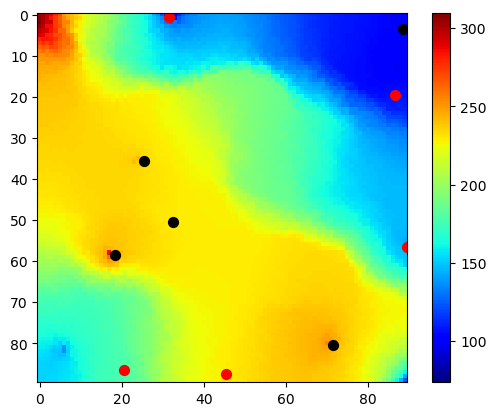

true


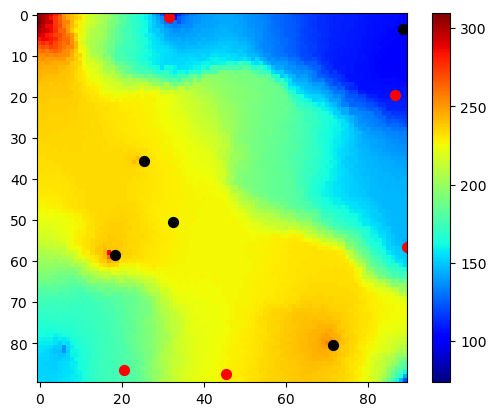

pred


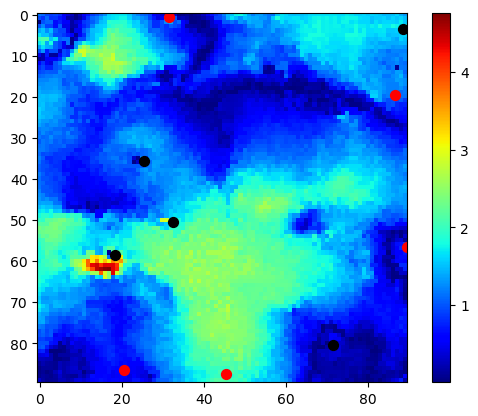

diff


In [59]:
real =0
start_ts = 49

well = wellLoc[1]
num_inj = len(well[0])
num_prd = len(well[1])
total_time = 1500.0 #unit: day 
time0= total_time//num_ts
for ts in range(start_ts,num_ts):
    print("timestep:{}".format(ts+1));print("time:{}days".format(time0*(ts+1)))
    plt.figure()
    p1=plt.imshow(pres_struct['true'][real][ts])
    for i in range(num_inj):
        well_x,well_y = Visualization_Unstructured_Trickies.unstructure_2_structure_trick_single_well(Nc,dx_struct,dy_struct,well[0][i], XYZ)
        plt.scatter(well_y,well_x, s=50, c='black', marker='o') # inj
    for i in range(num_prd):
        well_x,well_y = Visualization_Unstructured_Trickies.unstructure_2_structure_trick_single_well(Nc,dx_struct,dy_struct,well[1][i], XYZ)
        plt.scatter(well_y,well_x,  s=50, c='red', marker='o') # prod
    plt.colorbar(p1)
    plt.show()
    print('true')
    p2=plt.imshow(pres_struct['pred'][real][ts])
    for i in range(num_inj):
        well_x,well_y = Visualization_Unstructured_Trickies.unstructure_2_structure_trick_single_well(Nc,dx_struct,dy_struct,well[0][i], XYZ)
        plt.scatter(well_y,well_x, s=50, c='black', marker='o') # inj
    for i in range(num_prd):
        well_x,well_y = Visualization_Unstructured_Trickies.unstructure_2_structure_trick_single_well(Nc,dx_struct,dy_struct,well[1][i], XYZ)
        plt.scatter(well_y,well_x,  s=50, c='red', marker='o') # prod
    plt.colorbar(p2)
    plt.show()
    print('pred')
    p3=plt.imshow(pres_struct['diff'][real][ts])
    for i in range(num_inj):
        well_x,well_y = Visualization_Unstructured_Trickies.unstructure_2_structure_trick_single_well(Nc,dx_struct,dy_struct,well[0][i], XYZ)
        plt.scatter(well_y,well_x, s=50, c='black', marker='o') # inj
#         print(well_x,well_y)
    for i in range(num_prd):
        well_x,well_y = Visualization_Unstructured_Trickies.unstructure_2_structure_trick_single_well(Nc,dx_struct,dy_struct,well[1][i], XYZ)
        plt.scatter(well_y,well_x,  s=50, c='red', marker='o') # prod
#         print(well_x,well_y)
    plt.colorbar(p3)
    plt.show()
    print('diff')

In [60]:
gnn_inj_rate,gnn_prd_wrate,gnn_prd_orate = inj_rate,prd_wrate,prd_orate

In [61]:
def extract_rates_at_certain_time_steps(time, rate, target_time, num_ts, keyword):
    count = 0
    rate_ts = []
    for j in range(time.shape[0]):
        if target_time[count] == time[j]:
            rate_ts.append(rate[keyword][0,j])
            count += 1
            if count == num_ts:
                rate_ts = np.array(rate_ts)
                return rate_ts
    rate_ts = np.array(rate_ts)
    return rate_ts

def Read_ADGPRS_Rate(curr_dir,well_ids):   
    rate = {}
    sub_file_path = os.path.join(curr_dir, 'Output.rates.txt')

    data = pd.read_csv(sub_file_path, delim_whitespace=True)
   #     continue
    for well_id in well_ids:
        if well_id + ':WAT' not in rate:
            rate[well_id + ':WAT'], rate[well_id + ':OIL'] = [], []
        rate[well_id + ':WAT'].append(data[well_id + ':WAT'].values)
        rate[well_id + ':OIL'].append(data[well_id + ':OIL'].values)
    for key in rate:
        rate[key] = np.stack(rate[key], axis = 0)
    
    return data['Day'], rate 

def read_simulation_rates(cwd,num_cell,num_inj,num_prod,num_ts,wellLoc,time_step):
    well_ids = []
    for i in range(num_inj):
        well_ids.append('INJ'+str(i+1))
    for i in range(num_prod):
        well_ids.append('PRD'+str(i+1))
        
    inj_rate = np.zeros((num_inj,num_ts))
    prd_wrate = np.zeros((num_prod,num_ts))
    prd_orate = np.zeros((num_prod,num_ts))
    
    # the time point we are interested in [time_step,2*time_step,...,n*time_step] size same as num_ts
    target_time = []
    for i in range(num_ts):
        target_time.append(time_step*(i+1))

    # extract all rates info from ADGPRS
    time, rate =  Read_ADGPRS_Rate(cwd,well_ids)
    for i in range(num_inj):
        inj_rate[i] = extract_rates_at_certain_time_steps(time, rate,target_time,num_ts,'INJ'+str(i+1)+':WAT')
    for i in range(num_prod):
        prd_orate[i] = extract_rates_at_certain_time_steps(time, rate,target_time,num_ts,'PRD'+str(i+1)+':OIL')
        prd_wrate[i] = extract_rates_at_certain_time_steps(time, rate,target_time,num_ts,'PRD'+str(i+1)+':WAT')
    
    return inj_rate,prd_wrate,prd_orate

In [62]:
cwd = '/oak/stanford/schools/ees/smart_fields/hytang/uof_optimization_workflow/GNN_surrogate/Optimizations/WPO_one_BHP_ctrl_unstructured/gnnEval_testing/corresponding_sim_results'

In [63]:
inj_rate,prd_wrate,prd_orate = read_simulation_rates(cwd,num_cell,num_inj,num_prod,num_ts,wellLoc,time_per_step)

In [64]:
sim_inj_rate,sim_prd_wrate,sim_prd_orate = inj_rate,prd_wrate,prd_orate

In [65]:
num_time_step=50
time = []
time_step = total_time/num_time_step
for i in range(num_time_step):
    time.append((i+1)*time_step)
time = np.array(time)

realization_No.1


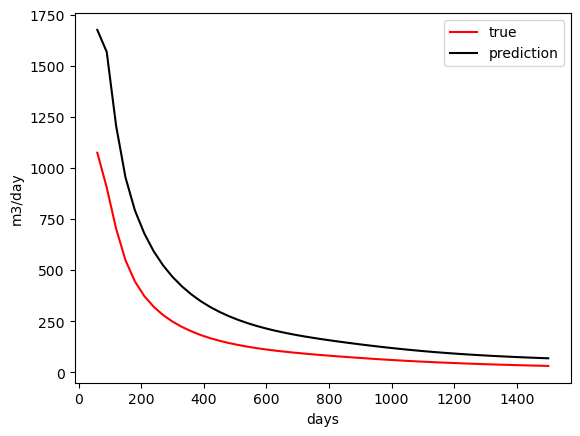

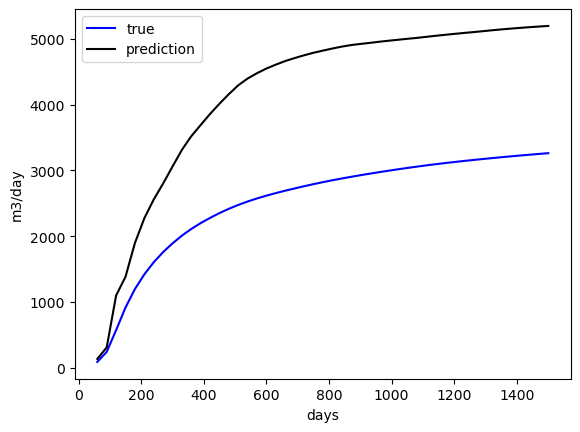

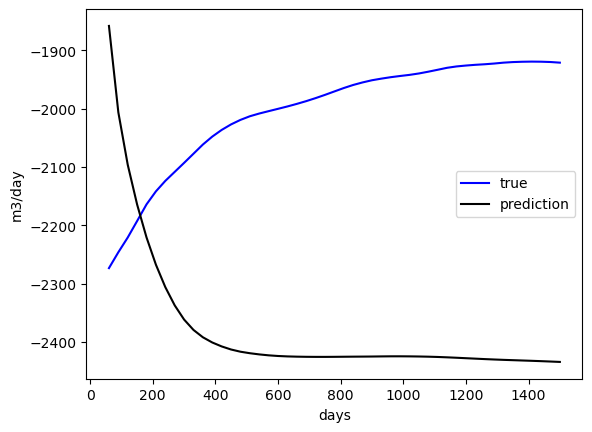

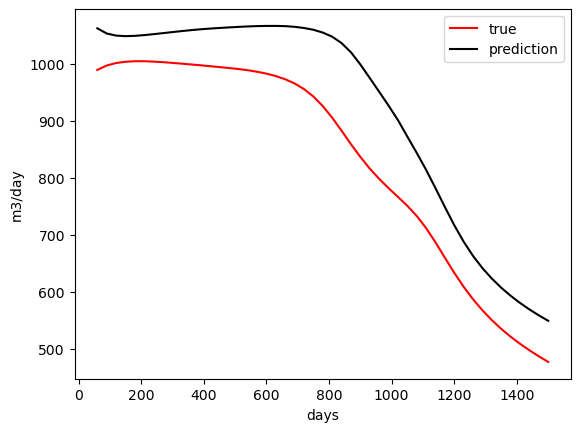

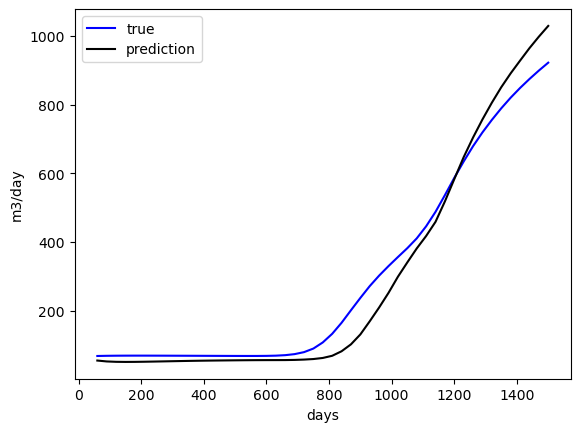

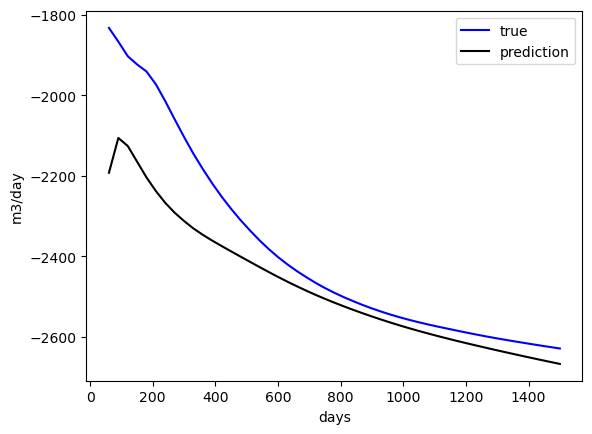

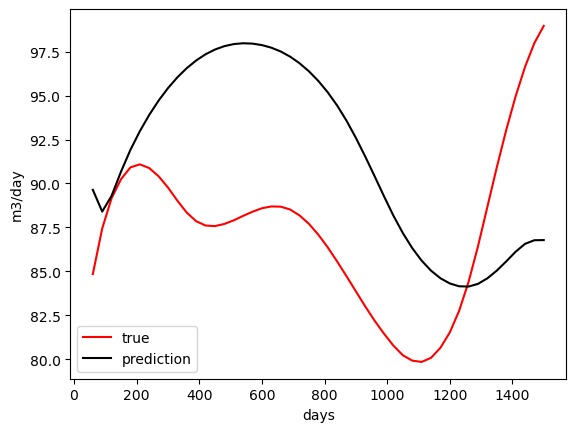

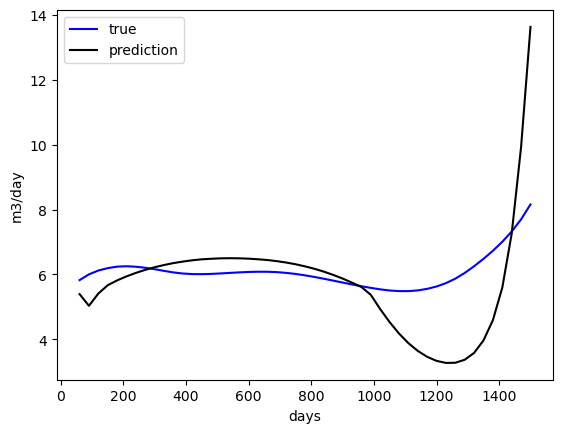

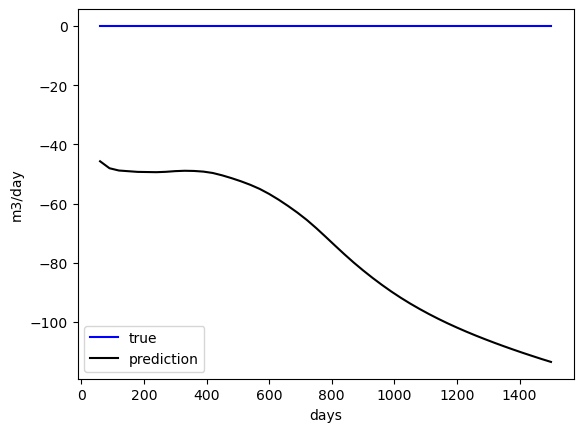

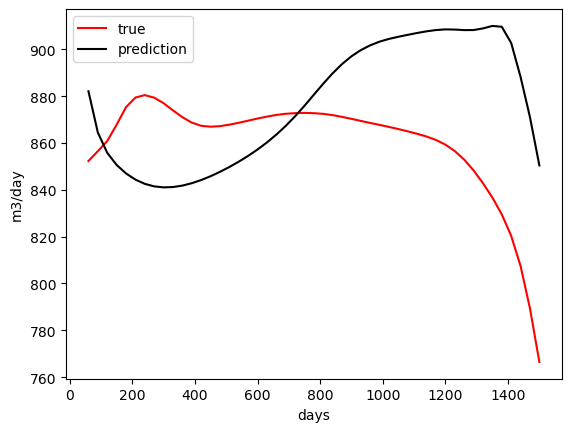

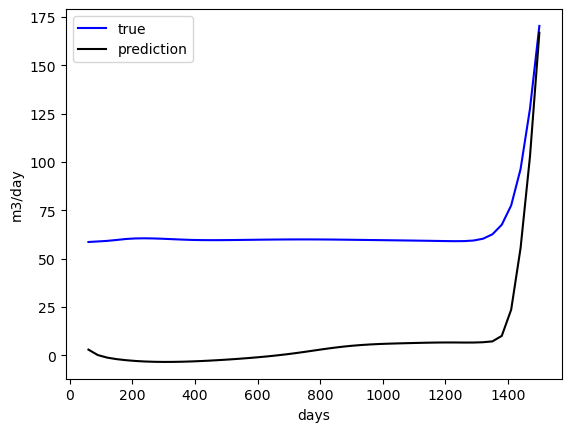

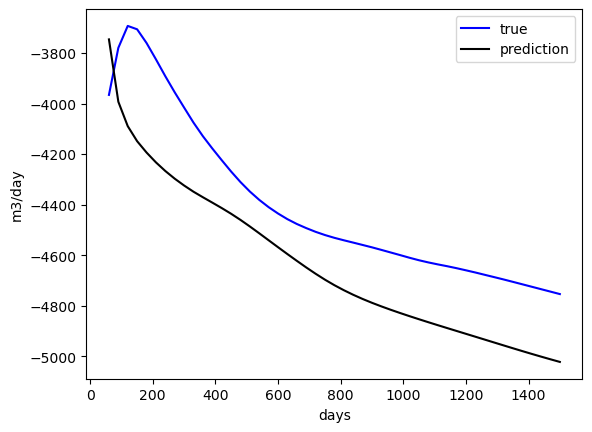

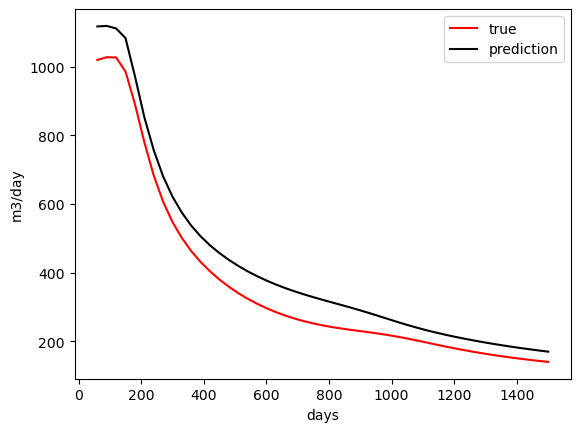

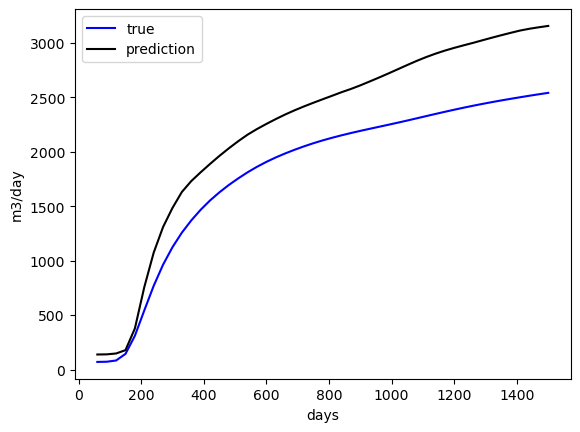

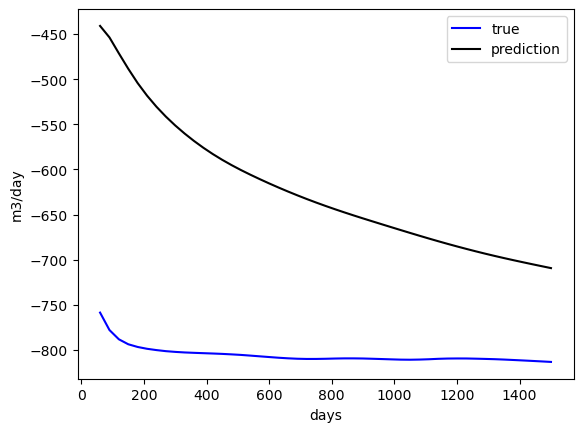

In [66]:
# plot the rates for both inj and prd/ treu and pred
start_idx = 1
real=0
print('realization_No.'+str(real+1))
for i in range(num_prd):
    fig = plt.figure()
    x = time[start_idx:]
    y1 = sim_prd_orate[i][start_idx:]
    plt.plot(x, y1,'r')
    y2 = gnn_prd_orate[i][start_idx:]
    plt.plot(x, y2,'k')
    plt.legend(['true','prediction'])
    plt.xlabel('days')
    plt.ylabel('m3/day')
    plt.show()
    plt.close(fig)
    
    fig = plt.figure()
    x = time[start_idx:]
    y1 = sim_prd_wrate[i][start_idx:]
    plt.plot(x, y1,'b')
    y2 = gnn_prd_wrate[i][start_idx:]
    plt.plot(x, y2,'k')
    plt.legend(['true','prediction'])
    plt.xlabel('days')
    plt.ylabel('m3/day')
    plt.show()
    plt.close(fig)
    
    fig = plt.figure()
    x = time[start_idx:]
    y1 = sim_inj_rate[i][start_idx:]
    plt.plot(x, y1,'b')
    y2 = gnn_inj_rate[i][start_idx:]
    plt.plot(x, y2,'k')
    plt.legend(['true','prediction'])
    plt.xlabel('days')
    plt.ylabel('m3/day')
    plt.show()
    plt.close(fig)



In [69]:
gnn_inj_rate.shape

(5, 50)